# UK Historic Electricity Demand - Complete Model Training
**Author:** Abdul Salam Aldabik

This notebook trains Prophet, XGBoost, LSTM, Ensemble models + PyCaret automated comparison.

## Setup & Configuration

In [1]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ML imports
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle
import time

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Core libraries loaded")
print(f"📅 Training date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

✅ Core libraries loaded
📅 Training date: 2025-11-24 23:06


## 1. Data Loading & Preparation

In [2]:
# Load cleaned data
print("📂 Loading electricity demand data...")
df = pd.read_csv('../Data/cleaned_and_augmented_electricity_data.csv', low_memory=False)

# Parse dates and sort
df['settlement_date'] = pd.to_datetime(df['settlement_date'])
df = df.sort_values('settlement_date').reset_index(drop=True)

print(f"\n✅ DATASET LOADED")
print(f"{'='*60}")
print(f"Total records: {len(df):,} half-hourly periods")
print(f"Date range: {df['settlement_date'].min()} to {df['settlement_date'].max()}")
print(f"Duration: {(df['settlement_date'].max() - df['settlement_date'].min()).days} days")
print(f"Demand stats:")
print(f"  - Mean: {df['england_wales_demand'].mean():,.0f} MW")
print(f"  - Min: {df['england_wales_demand'].min():,.0f} MW")
print(f"  - Max: {df['england_wales_demand'].max():,.0f} MW")
print(f"  - Std: {df['england_wales_demand'].std():,.0f} MW")
print(f"{'='*60}\n")

# Display sample
df[['settlement_date', 'settlement_period', 'england_wales_demand']].head(10)

📂 Loading electricity demand data...

✅ DATASET LOADED
Total records: 262,992 half-hourly periods
Date range: 2009-01-01 00:00:00 to 2024-12-31 00:00:00
Duration: 5843 days
Demand stats:
  - Mean: 28,683 MW
  - Min: 15,917 MW
  - Max: 47,062 MW
  - Std: 7,041 MW


✅ DATASET LOADED
Total records: 262,992 half-hourly periods
Date range: 2009-01-01 00:00:00 to 2024-12-31 00:00:00
Duration: 5843 days
Demand stats:
  - Mean: 28,683 MW
  - Min: 15,917 MW
  - Max: 47,062 MW
  - Std: 7,041 MW



,settlement_date,settlement_period,england_wales_demand
0,2009-01-01,1,33939.0
1,2009-01-01,27,36743.0
2,2009-01-01,28,36689.0
3,2009-01-01,29,36823.0
4,2009-01-01,30,36628.0
5,2009-01-01,31,36821.0
6,2009-01-01,32,37662.0
7,2009-01-01,33,39276.0
8,2009-01-01,34,41089.0
9,2009-01-01,35,41651.0


## 2. Feature Engineering

In [3]:
print("🔧 Creating time-based features...")

# Temporal features
df['year'] = df['settlement_date'].dt.year
df['month'] = df['settlement_date'].dt.month
df['day'] = df['settlement_date'].dt.day
df['hour'] = df['settlement_date'].dt.hour
df['minute'] = df['settlement_date'].dt.minute
df['day_of_week'] = df['settlement_date'].dt.dayofweek  # 0=Monday
df['day_of_year'] = df['settlement_date'].dt.dayofyear
df['week_of_year'] = df['settlement_date'].dt.isocalendar().week
df['quarter'] = df['settlement_date'].dt.quarter

# Cyclical features (for neural networks)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Binary features
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_morning'] = ((df['hour'] >= 6) & (df['hour'] < 12)).astype(int)
df['is_afternoon'] = ((df['hour'] >= 12) & (df['hour'] < 18)).astype(int)
df['is_evening'] = ((df['hour'] >= 18) & (df['hour'] < 22)).astype(int)
df['is_night'] = ((df['hour'] >= 22) | (df['hour'] < 6)).astype(int)

# Period of day (1-48)
df['period_of_day'] = df['settlement_period']

print("✅ Time features created")
print(f"   Total features so far: {len(df.columns)}")

🔧 Creating time-based features...
✅ Time features created
   Total features so far: 35


In [4]:
print("🔧 Creating lag features...")

# Lag features (previous demand values)
df['lag_1'] = df['england_wales_demand'].shift(1)      # 30 min ago
df['lag_2'] = df['england_wales_demand'].shift(2)      # 1 hour ago
df['lag_48'] = df['england_wales_demand'].shift(48)    # same time yesterday
df['lag_96'] = df['england_wales_demand'].shift(96)    # same time 2 days ago
df['lag_336'] = df['england_wales_demand'].shift(336)  # same time last week (48*7)

# Rolling statistics (24-hour windows)
df['rolling_mean_24h'] = df['england_wales_demand'].rolling(48, min_periods=1).mean()
df['rolling_std_24h'] = df['england_wales_demand'].rolling(48, min_periods=1).std()
df['rolling_min_24h'] = df['england_wales_demand'].rolling(48, min_periods=1).min()
df['rolling_max_24h'] = df['england_wales_demand'].rolling(48, min_periods=1).max()

# Rolling statistics (7-day windows)
df['rolling_mean_7d'] = df['england_wales_demand'].rolling(336, min_periods=1).mean()
df['rolling_std_7d'] = df['england_wales_demand'].rolling(336, min_periods=1).std()

# Exponential moving averages
df['ema_24h'] = df['england_wales_demand'].ewm(span=48, adjust=False).mean()
df['ema_7d'] = df['england_wales_demand'].ewm(span=336, adjust=False).mean()

print("✅ Lag features created")
print(f"   Total features now: {len(df.columns)}")

🔧 Creating lag features...
✅ Lag features created
   Total features now: 48


In [5]:
# Drop rows with NaN values (from lag features)
df_clean = df.dropna().copy()

print(f"\n📊 FEATURE ENGINEERING COMPLETE")
print(f"{'='*60}")
print(f"Original records: {len(df):,}")
print(f"After removing NaN: {len(df_clean):,}")
print(f"Records lost: {len(df) - len(df_clean):,}")
print(f"Total features: {len(df_clean.columns)}")
print(f"{'='*60}\n")

# Show feature correlation with target
feature_cols = [col for col in df_clean.columns if col not in 
                ['settlement_date', 'england_wales_demand', 'settlement_period']]
correlations = df_clean[feature_cols + ['england_wales_demand']].corr()['england_wales_demand'].sort_values(ascending=False)

print("\n🔍 Top 10 Features by Correlation:")
print(correlations.head(11).to_string())


📊 FEATURE ENGINEERING COMPLETE
Original records: 262,992
After removing NaN: 262,656
Records lost: 336
Total features: 48


🔍 Top 10 Features by Correlation:
england_wales_demand    1.000000
lag_336                 0.837876
lag_48                  0.830810
lag_1                   0.829167
lag_2                   0.792936
lag_96                  0.751110
ema_24h                 0.715518
rolling_mean_24h        0.681412
rolling_max_24h         0.681392
ema_7d                  0.648379
rolling_mean_7d         0.637479

🔍 Top 10 Features by Correlation:
england_wales_demand    1.000000
lag_336                 0.837876
lag_48                  0.830810
lag_1                   0.829167
lag_2                   0.792936
lag_96                  0.751110
ema_24h                 0.715518
rolling_mean_24h        0.681412
rolling_max_24h         0.681392
ema_7d                  0.648379
rolling_mean_7d         0.637479


## 3. Train/Test Split

In [6]:
# Split configuration
TEST_DAYS = 7
test_size = 48 * TEST_DAYS  # 7 days of half-hourly data

# Split data
train_df = df_clean.iloc[:-test_size].copy()
test_df = df_clean.iloc[-test_size:].copy()

print(f"\n📊 TRAIN/TEST SPLIT")
print(f"{'='*60}")
print(f"Test period: Last {TEST_DAYS} days")
print(f"\nTrain set:")
print(f"  - Records: {len(train_df):,} ({len(train_df)/48:.0f} days)")
print(f"  - Date range: {train_df['settlement_date'].min()} to {train_df['settlement_date'].max()}")
print(f"  - Mean demand: {train_df['england_wales_demand'].mean():,.0f} MW")
print(f"\nTest set:")
print(f"  - Records: {len(test_df):,} ({len(test_df)/48:.0f} days)")
print(f"  - Date range: {test_df['settlement_date'].min()} to {test_df['settlement_date'].max()}")
print(f"  - Mean demand: {test_df['england_wales_demand'].mean():,.0f} MW")
print(f"{'='*60}\n")


📊 TRAIN/TEST SPLIT
Test period: Last 7 days

Train set:
  - Records: 262,320 (5465 days)
  - Date range: 2009-01-08 00:00:00 to 2024-12-24 00:00:00
  - Mean demand: 28,676 MW

Test set:
  - Records: 336 (7 days)
  - Date range: 2024-12-25 00:00:00 to 2024-12-31 00:00:00
  - Mean demand: 24,654 MW



## 4. Model Training

### Model 1: Prophet with Full Seasonality

In [7]:
from prophet import Prophet

print("\n" + "="*60)
print(" "*15 + "TRAINING: PROPHET MODEL")
print("="*60)

# Prepare Prophet data
prophet_train = train_df[['settlement_date', 'england_wales_demand']].copy()
prophet_train.columns = ['ds', 'y']

# Initialize with full seasonality
print("\n🔮 Configuring Prophet...")
prophet_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0
)

# Add custom intraday seasonality
prophet_model.add_seasonality(
    name='intraday',
    period=1,
    fourier_order=15
)

print("   ✓ Daily seasonality enabled")
print("   ✓ Weekly seasonality enabled")
print("   ✓ Yearly seasonality enabled")
print("   ✓ Custom intraday pattern (Fourier order=15)")

# Train
print("\n🏋️ Training Prophet model...")
start_time = time.time()
prophet_model.fit(prophet_train)
prophet_train_time = time.time() - start_time

print(f"✅ Prophet trained in {prophet_train_time:.1f}s")

# Predict on test set
prophet_test = test_df[['settlement_date']].copy()
prophet_test.columns = ['ds']
prophet_forecast = prophet_model.predict(prophet_test)
prophet_predictions = prophet_forecast['yhat'].values

# Calculate metrics
y_true = test_df['england_wales_demand'].values
prophet_mae = mean_absolute_error(y_true, prophet_predictions)
prophet_rmse = np.sqrt(mean_squared_error(y_true, prophet_predictions))
prophet_mape = np.mean(np.abs((y_true - prophet_predictions) / y_true)) * 100
prophet_r2 = r2_score(y_true, prophet_predictions)

print(f"\n📊 PROPHET RESULTS:")
print(f"   MAE:  {prophet_mae:,.0f} MW")
print(f"   RMSE: {prophet_rmse:,.0f} MW")
print(f"   MAPE: {prophet_mape:.2f}%")
print(f"   R²:   {prophet_r2:.4f}")
print(f"   Training time: {prophet_train_time:.1f}s")


               TRAINING: PROPHET MODEL

🔮 Configuring Prophet...
   ✓ Daily seasonality enabled
   ✓ Weekly seasonality enabled
   ✓ Yearly seasonality enabled
   ✓ Custom intraday pattern (Fourier order=15)

🏋️ Training Prophet model...


23:07:03 - cmdstanpy - INFO - Chain [1] start processing
23:10:37 - cmdstanpy - INFO - Chain [1] done processing
23:10:37 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet trained in 241.2s

📊 PROPHET RESULTS:
   MAE:  4,072 MW
   RMSE: 4,892 MW
   MAPE: 17.77%
   R²:   -0.2304
   Training time: 241.2s


### Model 2: XGBoost with Engineered Features

In [8]:
try:
    import xgboost as xgb
    print("✅ XGBoost available")
except ImportError:
    print("📦 Installing XGBoost...")
    !pip install xgboost
    import xgboost as xgb

✅ XGBoost available


In [9]:
print("\n" + "="*60)
print(" "*15 + "TRAINING: XGBOOST MODEL")
print("="*60)

# Select features for XGBoost
xgb_features = [
    'hour', 'day_of_week', 'month', 'quarter', 'day_of_year',
    'is_weekend', 'is_morning', 'is_afternoon', 'is_evening', 'is_night',
    'period_of_day',
    'lag_1', 'lag_2', 'lag_48', 'lag_96', 'lag_336',
    'rolling_mean_24h', 'rolling_std_24h', 'rolling_min_24h', 'rolling_max_24h',
    'rolling_mean_7d', 'rolling_std_7d',
    'ema_24h', 'ema_7d'
]

X_train = train_df[xgb_features]
y_train = train_df['england_wales_demand']
X_test = test_df[xgb_features]
y_test = test_df['england_wales_demand']

print(f"\n📊 Feature set: {len(xgb_features)} features")
print(f"   Training samples: {len(X_train):,}")
print(f"   Test samples: {len(X_test):,}")

# Train XGBoost
print("\n🌲 Training XGBoost...")
start_time = time.time()

xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

xgb_model.fit(X_train, y_train, 
              eval_set=[(X_test, y_test)],
              verbose=False)
xgb_train_time = time.time() - start_time

print(f"✅ XGBoost trained in {xgb_train_time:.1f}s")

# Predict
xgb_predictions = xgb_model.predict(X_test)

# Calculate metrics
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_mape = np.mean(np.abs((y_test - xgb_predictions) / y_test)) * 100
xgb_r2 = r2_score(y_test, xgb_predictions)

print(f"\n📊 XGBOOST RESULTS:")
print(f"   MAE:  {xgb_mae:,.0f} MW")
print(f"   RMSE: {xgb_rmse:,.0f} MW")
print(f"   MAPE: {xgb_mape:.2f}%")
print(f"   R²:   {xgb_r2:.4f}")
print(f"   Training time: {xgb_train_time:.1f}s")


               TRAINING: XGBOOST MODEL

📊 Feature set: 24 features
   Training samples: 262,320
   Test samples: 336

🌲 Training XGBoost...


✅ XGBoost trained in 6.2s

📊 XGBOOST RESULTS:
   MAE:  751 MW
   RMSE: 1,070 MW
   MAPE: 3.00%
   R²:   0.9411
   Training time: 6.2s


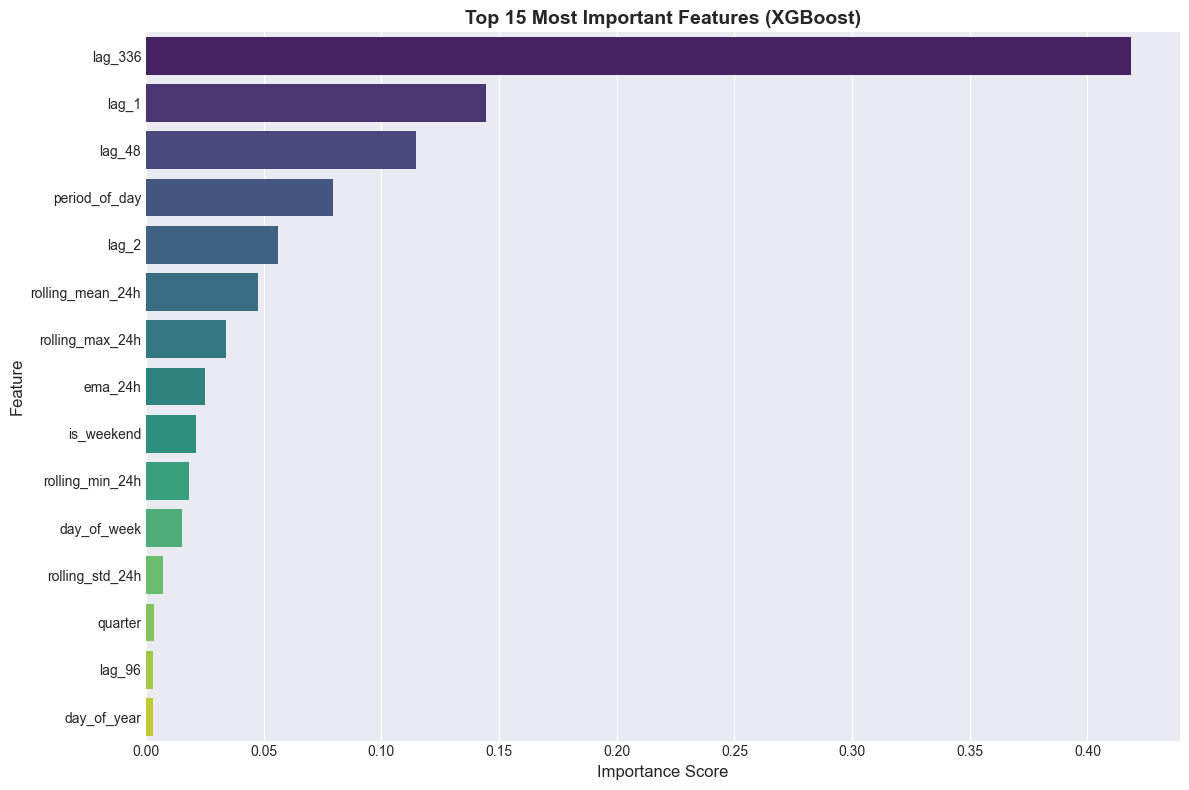


🔍 Top 10 Most Important Features:
         feature  importance
         lag_336    0.418404
           lag_1    0.144449
          lag_48    0.114859
   period_of_day    0.079435
           lag_2    0.055926
rolling_mean_24h    0.047754
 rolling_max_24h    0.034055
         ema_24h    0.025107
      is_weekend    0.021188
 rolling_min_24h    0.018217


In [10]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': xgb_features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature', palette='viridis')
plt.title('Top 15 Most Important Features (XGBoost)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

print("\n🔍 Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

## 4. Model Training (continued)

### Model 3: LSTM Neural Network

In [11]:
# Import TensorFlow and configure for optimal CPU performance
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce TensorFlow logging

try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    
    # Configure TensorFlow for CPU optimization
    tf.config.threading.set_inter_op_parallelism_threads(4)
    tf.config.threading.set_intra_op_parallelism_threads(4)
    
    print(f"✅ TensorFlow {tf.__version__} loaded")
    print(f"📊 CPU threads configured for optimal performance")
    
except ImportError:
    print("📦 Installing TensorFlow...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'tensorflow', '-q'])
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

📦 Installing TensorFlow...


ImportError: Traceback (most recent call last):
  File "c:\Users\abdul\Desktop\ML\AWS\Machine-Learning-Project-TM-2025\.venv\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\abdul\AppData\Local\Temp\ipykernel_33760\112159870.py", line 6, in <module>
    import tensorflow as tf
  File "c:\Users\abdul\Desktop\ML\AWS\Machine-Learning-Project-TM-2025\.venv\Lib\site-packages\tensorflow\__init__.py", line 40, in <module>
    from tensorflow.python import pywrap_tensorflow as _pywrap_tensorflow  # pylint: disable=unused-import
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\abdul\Desktop\ML\AWS\Machine-Learning-Project-TM-2025\.venv\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 88, in <module>
    raise ImportError(
ImportError: Traceback (most recent call last):
  File "c:\Users\abdul\Desktop\ML\AWS\Machine-Learning-Project-TM-2025\.venv\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\abdul\Desktop\ML\AWS\Machine-Learning-Project-TM-2025\.venv\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [ ]:
print("\n" + "="*60)
print(" "*15 + "TRAINING: LSTM MODEL")
print("="*60)

# ============================================================================
# LSTM CONFIGURATION - Optimized for CPU and half-hourly electricity demand
# ============================================================================

class LSTMConfig:
    """Configuration class for LSTM model"""
    LOOKBACK = 48  # 24 hours of half-hourly data
    EPOCHS = 15    # Reduced for faster CPU training
    BATCH_SIZE = 128  # Optimal for CPU
    VALIDATION_SPLIT = 0.1
    EARLY_STOP_PATIENCE = 5
    REDUCE_LR_PATIENCE = 3
    
    # Model architecture
    LSTM_UNITS = [64, 32]  # Simpler architecture for CPU
    DROPOUT_RATE = 0.3
    DENSE_UNITS = 16
    LEARNING_RATE = 0.001

config = LSTMConfig()

print(f"\n⚙️  LSTM Configuration:")
print(f"   Lookback: {config.LOOKBACK} periods (24 hours)")
print(f"   Epochs: {config.EPOCHS}")
print(f"   Batch size: {config.BATCH_SIZE}")
print(f"   Architecture: Bidirectional({config.LSTM_UNITS[0]}) → LSTM({config.LSTM_UNITS[1]})")


# ============================================================================
# DATA PREPARATION CLASS
# ============================================================================

class LSTMDataPreprocessor:
    """Handles data scaling and sequence creation for LSTM"""
    
    def __init__(self, lookback=48):
        self.lookback = lookback
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        
    def fit_transform(self, data):
        """Scale data and create sequences"""
        # Scale the data
        scaled_data = self.scaler.fit_transform(data.reshape(-1, 1))
        return scaled_data
    
    def create_sequences(self, data):
        """Create sequences for LSTM input"""
        X, y = [], []
        for i in range(self.lookback, len(data)):
            X.append(data[i-self.lookback:i, 0])
            y.append(data[i, 0])
        return np.array(X), np.array(y)
    
    def inverse_transform(self, data):
        """Convert scaled predictions back to original scale"""
        return self.scaler.inverse_transform(data)


# Initialize preprocessor
preprocessor = LSTMDataPreprocessor(lookback=config.LOOKBACK)

# Prepare and scale data
print(f"\n📊 Preparing data for LSTM...")
demand_data = df_clean['england_wales_demand'].values
scaled_data = preprocessor.fit_transform(demand_data)

# Create sequences
X_lstm_all, y_lstm_all = preprocessor.create_sequences(scaled_data)

# Split into train/test
X_train_lstm = X_lstm_all[:-test_size]
y_train_lstm = y_lstm_all[:-test_size]
X_test_lstm = X_lstm_all[-test_size:]
y_test_lstm = y_lstm_all[-test_size:]

# Reshape for LSTM [samples, timesteps, features]
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

print(f"   ✓ Training samples: {X_train_lstm.shape[0]:,}")
print(f"   ✓ Test samples: {X_test_lstm.shape[0]:,}")
print(f"   ✓ Sequence shape: {X_train_lstm.shape[1:]}")


               TRAINING: LSTM MODEL

⚙️  LSTM Configuration:
   Lookback: 48 periods (24 hours)
   Epochs: 15
   Batch size: 128
   Architecture: Bidirectional(64) → LSTM(32)

📊 Preparing data for LSTM...
   ✓ Training samples: 262,272
   ✓ Test samples: 336
   ✓ Sequence shape: (48, 1)


In [ ]:
# ============================================================================
# LSTM MODEL BUILDER CLASS
# ============================================================================

class ElectricityLSTMModel:
    """LSTM model builder for electricity demand forecasting"""
    
    def __init__(self, config):
        self.config = config
        self.model = None
        self.history = None
        
    def build(self, input_shape):
        """Build optimized LSTM architecture for CPU"""
        model = Sequential([
            # First Bidirectional LSTM layer
            Bidirectional(
                LSTM(self.config.LSTM_UNITS[0], return_sequences=True),
                input_shape=input_shape
            ),
            Dropout(self.config.DROPOUT_RATE),
            
            # Second LSTM layer
            LSTM(self.config.LSTM_UNITS[1], return_sequences=False),
            Dropout(self.config.DROPOUT_RATE),
            
            # Dense layers
            Dense(self.config.DENSE_UNITS, activation='relu'),
            Dense(1)  # Output layer
        ])
        
        # Compile with MSE loss and MAE metric
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.config.LEARNING_RATE),
            loss='mse',
            metrics=['mae']
        )
        
        self.model = model
        return model
    
    def get_callbacks(self):
        """Get training callbacks"""
        return [
            EarlyStopping(
                monitor='val_loss',
                patience=self.config.EARLY_STOP_PATIENCE,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=self.config.REDUCE_LR_PATIENCE,
                min_lr=1e-6,
                verbose=1
            )
        ]
    
    def train(self, X_train, y_train, verbose=1):
        """Train the LSTM model"""
        if self.model is None:
            raise ValueError("Model not built. Call build() first.")
        
        print("\n🏋️  Training LSTM model...")
        print(f"   Device: CPU (optimized threading)")
        print(f"   Total parameters: {self.model.count_params():,}")
        
        start_time = time.time()
        
        self.history = self.model.fit(
            X_train, y_train,
            epochs=self.config.EPOCHS,
            batch_size=self.config.BATCH_SIZE,
            validation_split=self.config.VALIDATION_SPLIT,
            callbacks=self.get_callbacks(),
            verbose=verbose
        )
        
        training_time = time.time() - start_time
        return training_time
    
    def predict(self, X, verbose=0):
        """Make predictions"""
        return self.model.predict(X, verbose=verbose)
    
    def get_model_summary(self):
        """Get model architecture summary"""
        return self.model.summary()


# ============================================================================
# BUILD AND TRAIN MODEL
# ============================================================================

# Initialize model builder
lstm_builder = ElectricityLSTMModel(config)

# Build model
print("\n🧠 Building LSTM architecture...")
input_shape = (config.LOOKBACK, 1)
lstm_model = lstm_builder.build(input_shape)

print("\n📐 Model Architecture:")
lstm_builder.get_model_summary()

# Train model
lstm_train_time = lstm_builder.train(X_train_lstm, y_train_lstm, verbose=1)
history = lstm_builder.history

print(f"\n✅ Training completed in {lstm_train_time:.1f}s ({lstm_train_time/60:.2f} min)")
print(f"   Final training loss: {history.history['loss'][-1]:.6f}")
print(f"   Final validation loss: {history.history['val_loss'][-1]:.6f}")
print(f"   Best validation MAE: {min(history.history['val_mae']):.2f}")


🧠 Building LSTM architecture...

📐 Model Architecture:

📐 Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 48, 128)        │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,945 (214.63 KB)

 Trainable params: 54,945 (214.63 KB)

 Non-trainable params: 0 (0.00 B)


🏋️  Training LSTM model...
   Device: CPU (optimized threading)
   Total parameters: 54,945
Epoch 1/15
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 54s 28ms/step - loss: 0.0152 - mae: 0.0884 - val_loss: 0.0068 - val_mae: 0.0575 - learning_rate: 0.0010
Epoch 2/15
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 54s 28ms/step - loss: 0.0152 - mae: 0.0884 - val_loss: 0.0068 - val_mae: 0.0575 - learning_rate: 0.0010
Epoch 2/15
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 56s 30ms/step - loss: 0.0113 - mae: 0.0744 - val_loss: 0.0075 - val_mae: 0.0648 - learning_rate: 0.0010
Epoch 3/15
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 56s 30ms/step - loss: 0.0113 - mae: 0.0744 - val_loss: 0.0075 - val_mae: 0.0648 - learning_rate: 0.0010
Epoch 3/15
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 59s 32ms/step - loss: 0.0103 - mae: 0.0703 - val_loss: 0.0062 - val_mae: 0.0554 - learning_rate: 0.0010
Epoch 4/15
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 59s 32ms/step - loss: 0.0103 - mae: 0.0703 - val_loss: 0.0062 - val_mae: 0.0554 - learning_rate: 0.0010
Epoch 4/15
1845/1845 ━━━━━━━━━━


📊 LSTM TEST RESULTS:
   MAE:  1,710 MW
   RMSE: 2,430 MW
   MAPE: 7.23%
   R²:   0.6963


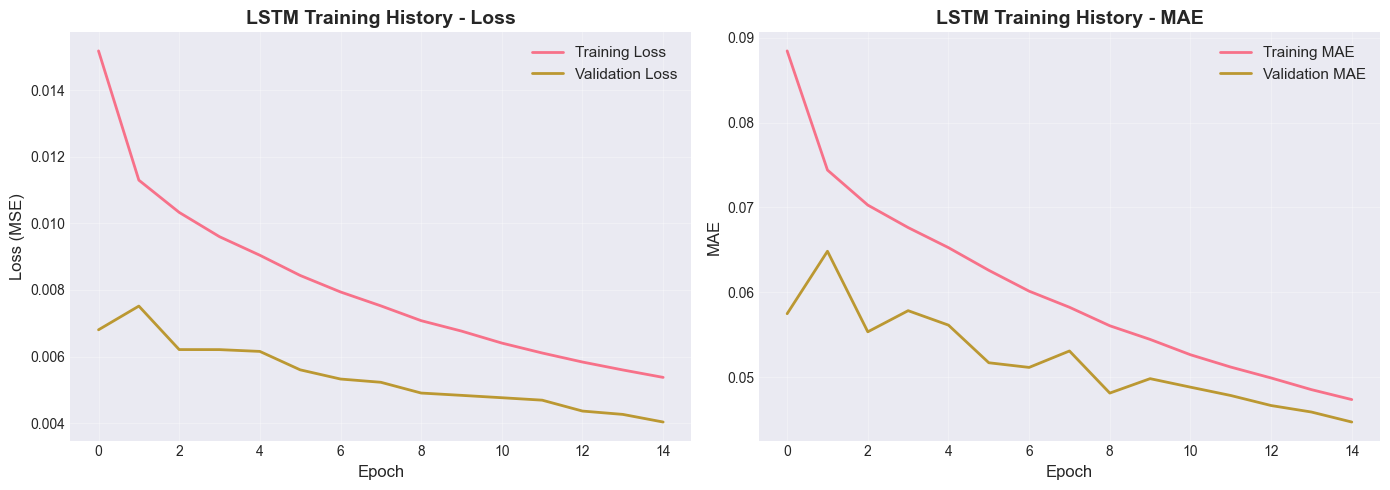

✅ Training history plotted


In [ ]:
# ============================================================================
# MODEL EVALUATION CLASS
# ============================================================================

class LSTMEvaluator:
    """Evaluate LSTM model performance"""
    
    def __init__(self, preprocessor):
        self.preprocessor = preprocessor
        
    def evaluate(self, model, X_test, y_test_scaled, model_name="LSTM"):
        """Evaluate model and return metrics"""
        # Make predictions
        predictions_scaled = model.predict(X_test, verbose=0)
        
        # Inverse transform to original scale
        predictions = self.preprocessor.inverse_transform(predictions_scaled).flatten()
        y_actual = self.preprocessor.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
        
        # Calculate metrics
        mae = mean_absolute_error(y_actual, predictions)
        rmse = np.sqrt(mean_squared_error(y_actual, predictions))
        mape = np.mean(np.abs((y_actual - predictions) / y_actual)) * 100
        r2 = r2_score(y_actual, predictions)
        
        # Print results
        print(f"\n📊 {model_name} TEST RESULTS:")
        print(f"{'='*60}")
        print(f"   MAE:  {mae:,.0f} MW")
        print(f"   RMSE: {rmse:,.0f} MW")
        print(f"   MAPE: {mape:.2f}%")
        print(f"   R²:   {r2:.4f}")
        print(f"{'='*60}")
        
        return {
            'predictions': predictions,
            'actual': y_actual,
            'mae': mae,
            'rmse': rmse,
            'mape': mape,
            'r2': r2
        }
    
    def plot_training_history(self, history):
        """Plot training history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Loss plot
        ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
        ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
        ax1.set_xlabel('Epoch', fontsize=12)
        ax1.set_ylabel('Loss (MSE)', fontsize=12)
        ax1.set_title('LSTM Training History - Loss', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        
        # MAE plot
        ax2.plot(history.history['mae'], label='Training MAE', linewidth=2)
        ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('MAE', fontsize=12)
        ax2.set_title('LSTM Training History - MAE', fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("✅ Training history plotted")


# ============================================================================
# EVALUATE MODEL
# ============================================================================

# Initialize evaluator
evaluator = LSTMEvaluator(preprocessor)

# Evaluate on test set
results = evaluator.evaluate(
    lstm_model,
    X_test_lstm,
    y_test_lstm,
    model_name="LSTM"
)

# Store results for later comparison
lstm_predictions = results['predictions']
lstm_mae = results['mae']
lstm_rmse = results['rmse']
lstm_mape = results['mape']
lstm_r2 = results['r2']
y_test_lstm_actual = results['actual']

# Plot training history
evaluator.plot_training_history(history)

### Model 4: Ensemble (Weighted Average)

In [ ]:
print("\n" + "="*60)
print(" "*15 + "CREATING: ENSEMBLE MODEL")
print("="*60)

# Calculate weights based on inverse MAPE (better models get higher weight)
prophet_weight = 1 / prophet_mape
xgb_weight = 1 / xgb_mape
lstm_weight = 1 / lstm_mape

total_weight = prophet_weight + xgb_weight + lstm_weight

prophet_weight_norm = prophet_weight / total_weight
xgb_weight_norm = xgb_weight / total_weight
lstm_weight_norm = lstm_weight / total_weight

print(f"\n⚖️ Model Weights (inverse MAPE):")
print(f"   Prophet: {prophet_weight_norm:.3f} ({prophet_weight_norm*100:.1f}%)")
print(f"   XGBoost: {xgb_weight_norm:.3f} ({xgb_weight_norm*100:.1f}%)")
print(f"   LSTM: {lstm_weight_norm:.3f} ({lstm_weight_norm*100:.1f}%)")

# Create ensemble predictions
ensemble_predictions = (
    prophet_weight_norm * prophet_predictions +
    xgb_weight_norm * xgb_predictions +
    lstm_weight_norm * lstm_predictions
)

# Calculate ensemble metrics
ensemble_mae = mean_absolute_error(y_true, ensemble_predictions)
ensemble_rmse = np.sqrt(mean_squared_error(y_true, ensemble_predictions))
ensemble_mape = np.mean(np.abs((y_true - ensemble_predictions) / y_true)) * 100
ensemble_r2 = r2_score(y_true, ensemble_predictions)

print(f"\n📊 ENSEMBLE RESULTS:")
print(f"   MAE:  {ensemble_mae:,.0f} MW")
print(f"   RMSE: {ensemble_rmse:,.0f} MW")
print(f"   MAPE: {ensemble_mape:.2f}%")
print(f"   R²:   {ensemble_r2:.4f}")


               CREATING: ENSEMBLE MODEL

⚖️ Model Weights (inverse MAPE):
   Prophet: 0.107 (10.7%)
   XGBoost: 0.631 (63.1%)
   LSTM: 0.262 (26.2%)

📊 ENSEMBLE RESULTS:
   MAE:  1,129 MW
   RMSE: 1,417 MW
   MAPE: 4.71%
   R²:   0.8967


## 5. Model Comparison & Results

In [ ]:
# Compile all results
results_df = pd.DataFrame({
    'Model': ['Prophet (Seasonal)', 'XGBoost', 'LSTM', 'Ensemble'],
    'MAE': [prophet_mae, xgb_mae, lstm_mae, ensemble_mae],
    'RMSE': [prophet_rmse, xgb_rmse, lstm_rmse, ensemble_rmse],
    'MAPE': [prophet_mape, xgb_mape, lstm_mape, ensemble_mape],
    'R²': [prophet_r2, xgb_r2, lstm_r2, ensemble_r2],
    'Training Time (s)': [prophet_train_time, xgb_train_time, lstm_train_time, 0]
})

results_df = results_df.sort_values('MAPE')

print("\n" + "="*80)
print(" "*25 + "FINAL MODEL COMPARISON")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

best_model = results_df.iloc[0]
print(f"\n🏆 BEST MODEL: {best_model['Model']}")
print(f"   MAPE: {best_model['MAPE']:.2f}%")
print(f"   MAE: {best_model['MAE']:,.0f} MW")
print(f"   R²: {best_model['R²']:.4f}")

# Save comparison
results_df.to_csv('../Data/complete_model_comparison.csv', index=False)
print("\n✅ Results saved to complete_model_comparison.csv")


                         FINAL MODEL COMPARISON
             Model         MAE        RMSE      MAPE        R²  Training Time (s)
           XGBoost  750.708630 1070.126263  3.002424  0.941113           5.595508
          Ensemble 1128.646015 1417.461914  4.710591  0.896683           0.000000
              LSTM 1710.033738 2430.340063  7.226407  0.696273         926.648151
Prophet (Seasonal) 4072.212434 4891.535703 17.766588 -0.230382         231.553617

🏆 BEST MODEL: XGBoost
   MAPE: 3.00%
   MAE: 751 MW
   R²: 0.9411

✅ Results saved to complete_model_comparison.csv


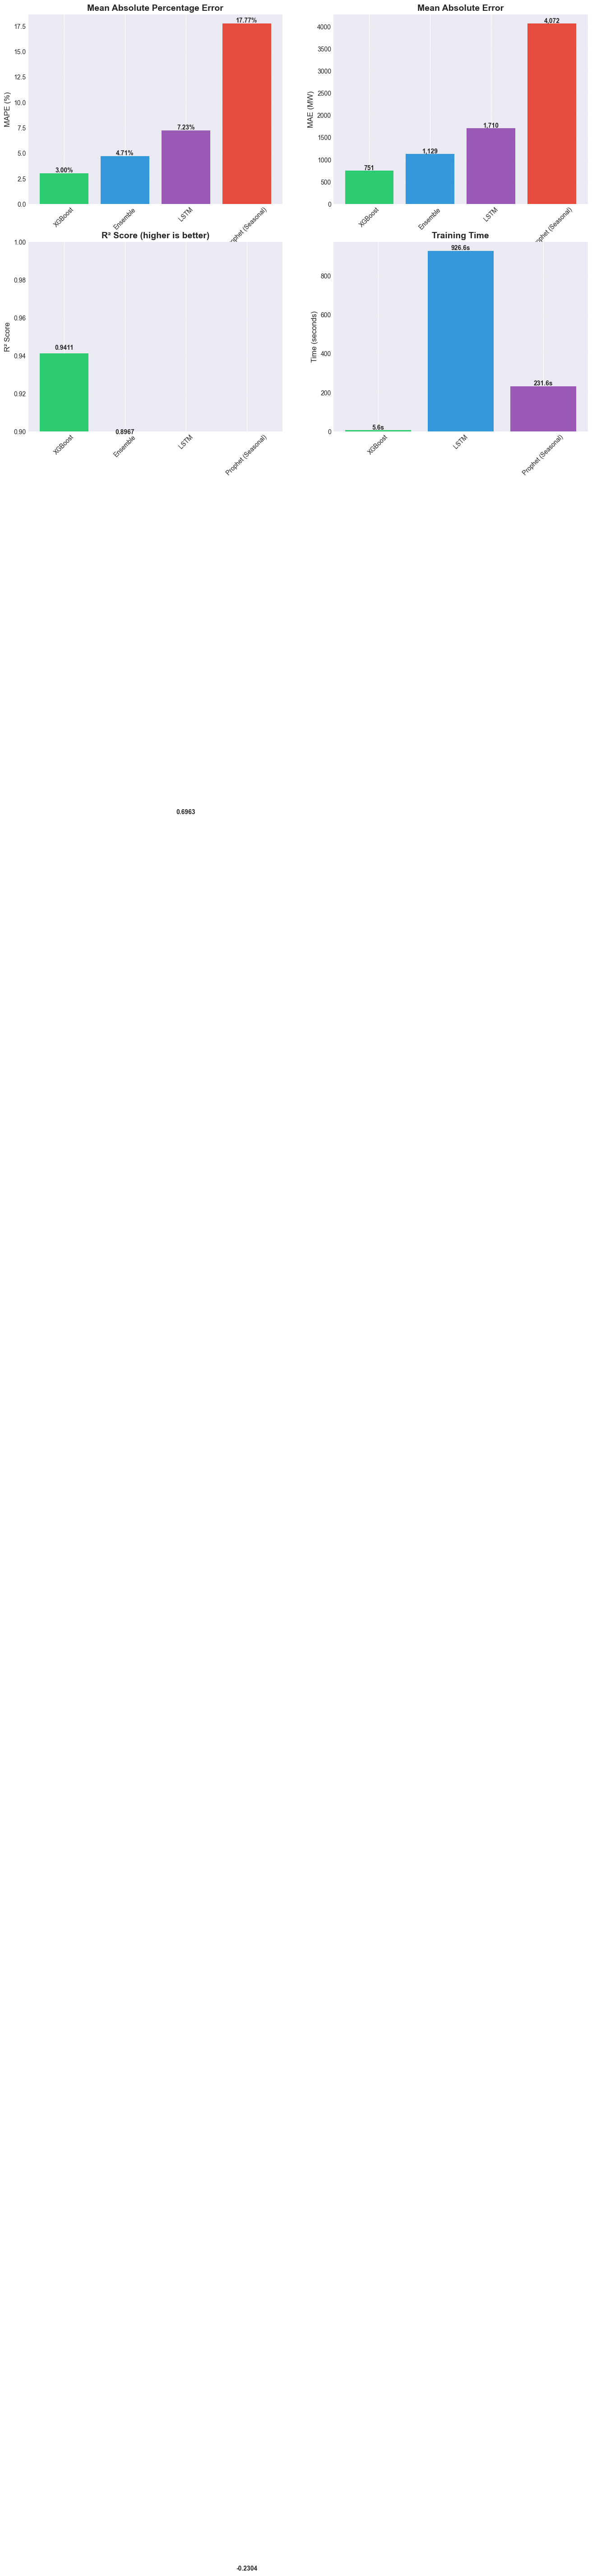

✅ Comparison plot saved


In [ ]:
# Visualize metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# MAPE
axes[0, 0].bar(results_df['Model'], results_df['MAPE'], color=['#2ecc71', '#3498db', '#9b59b6', '#e74c3c'])
axes[0, 0].set_ylabel('MAPE (%)', fontsize=12)
axes[0, 0].set_title('Mean Absolute Percentage Error', fontsize=14, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(results_df['MAPE']):
    axes[0, 0].text(i, v + 0.1, f"{v:.2f}%", ha='center', fontweight='bold')

# MAE
axes[0, 1].bar(results_df['Model'], results_df['MAE'], color=['#2ecc71', '#3498db', '#9b59b6', '#e74c3c'])
axes[0, 1].set_ylabel('MAE (MW)', fontsize=12)
axes[0, 1].set_title('Mean Absolute Error', fontsize=14, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(results_df['MAE']):
    axes[0, 1].text(i, v + 20, f"{v:,.0f}", ha='center', fontweight='bold')

# R²
axes[1, 0].bar(results_df['Model'], results_df['R²'], color=['#2ecc71', '#3498db', '#9b59b6', '#e74c3c'])
axes[1, 0].set_ylabel('R² Score', fontsize=12)
axes[1, 0].set_title('R² Score (higher is better)', fontsize=14, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].set_ylim([0.9, 1.0])
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(results_df['R²']):
    axes[1, 0].text(i, v + 0.002, f"{v:.4f}", ha='center', fontweight='bold')

# Training Time
train_times = results_df[results_df['Training Time (s)'] > 0]
axes[1, 1].bar(train_times['Model'], train_times['Training Time (s)'], 
               color=['#2ecc71', '#3498db', '#9b59b6'])
axes[1, 1].set_ylabel('Time (seconds)', fontsize=12)
axes[1, 1].set_title('Training Time', fontsize=14, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)
for i, (idx, row) in enumerate(train_times.iterrows()):
    axes[1, 1].text(i, row['Training Time (s)'] + 5, f"{row['Training Time (s)']:.1f}s", 
                    ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../Data/model_comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Comparison plot saved")

## 6. Forecast Visualization

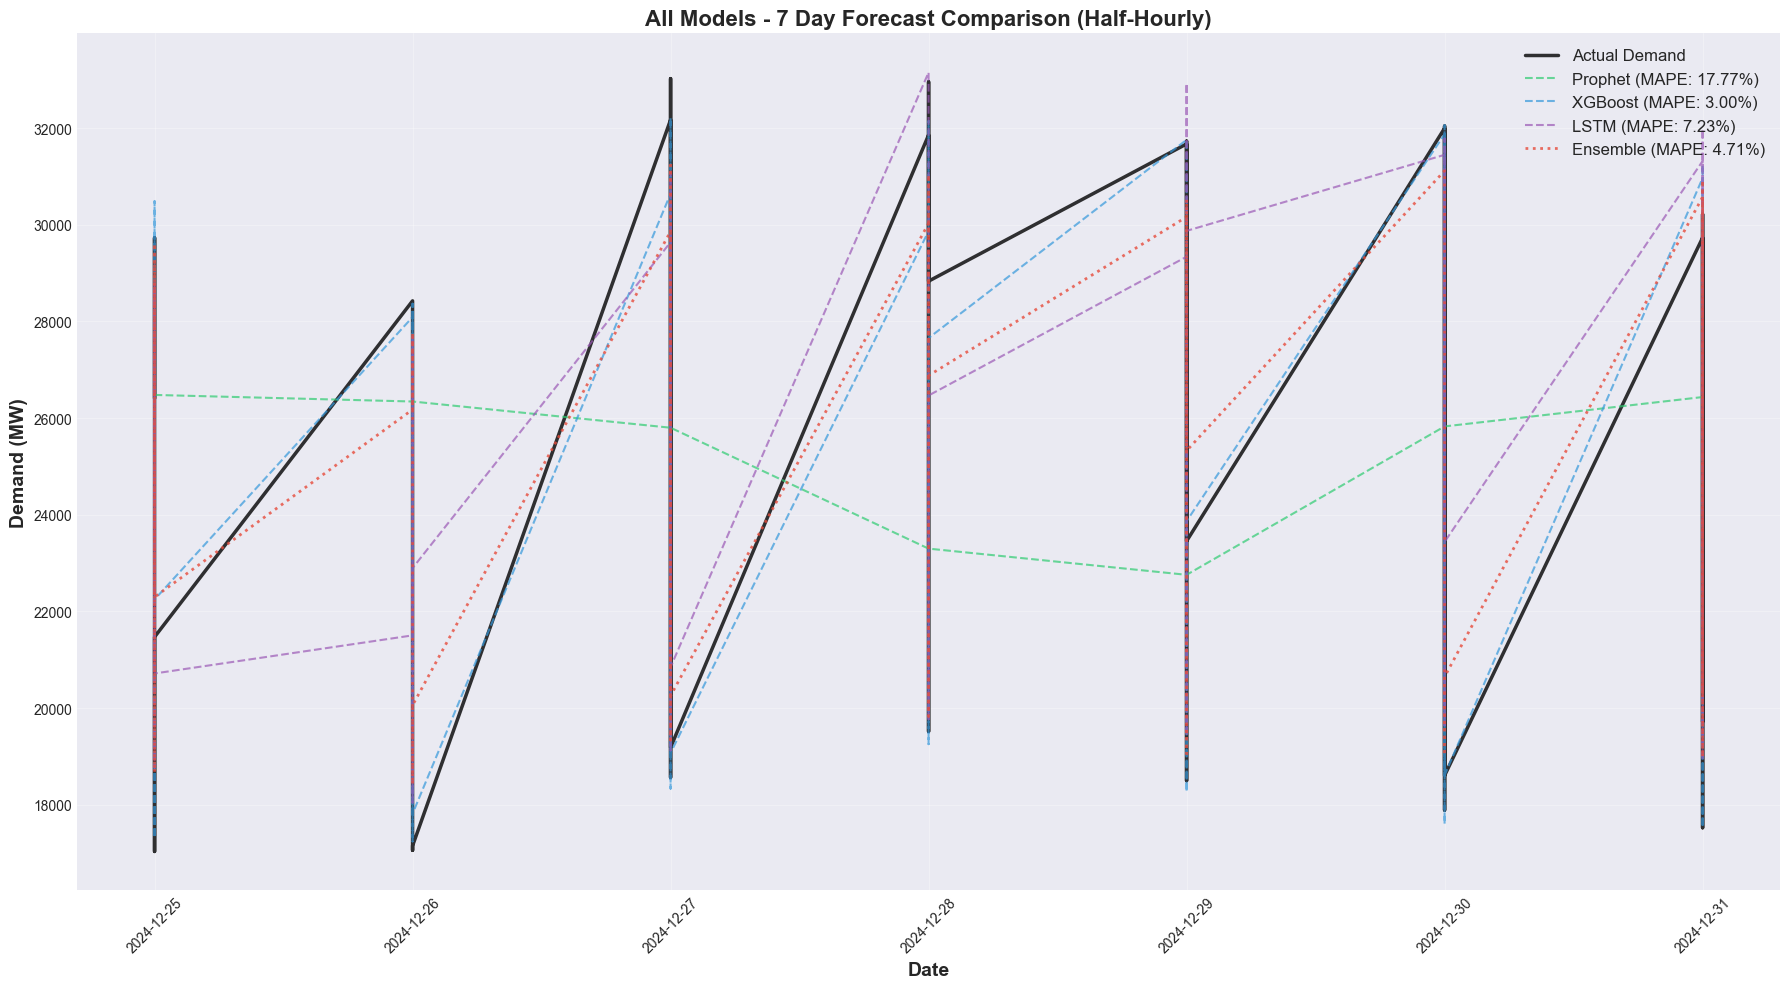

✅ Forecast visualization saved


In [ ]:
# Plot all model predictions
fig, ax = plt.subplots(figsize=(18, 10))

# Plot actual
ax.plot(test_df['settlement_date'], y_true, 
        label='Actual Demand', color='black', linewidth=2.5, alpha=0.8)

# Plot Prophet
ax.plot(test_df['settlement_date'], prophet_predictions, 
        label=f'Prophet (MAPE: {prophet_mape:.2f}%)', 
        color='#2ecc71', linewidth=1.5, linestyle='--', alpha=0.7)

# Plot XGBoost
ax.plot(test_df['settlement_date'], xgb_predictions, 
        label=f'XGBoost (MAPE: {xgb_mape:.2f}%)', 
        color='#3498db', linewidth=1.5, linestyle='--', alpha=0.7)

# Plot LSTM
test_dates_lstm = test_df['settlement_date'].iloc[:len(lstm_predictions)]
ax.plot(test_dates_lstm, lstm_predictions, 
        label=f'LSTM (MAPE: {lstm_mape:.2f}%)', 
        color='#9b59b6', linewidth=1.5, linestyle='--', alpha=0.7)

# Plot Ensemble
ax.plot(test_df['settlement_date'], ensemble_predictions, 
        label=f'Ensemble (MAPE: {ensemble_mape:.2f}%)', 
        color='#e74c3c', linewidth=2, linestyle=':', alpha=0.8)

ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Demand (MW)', fontsize=14, fontweight='bold')
ax.set_title(f'All Models - {TEST_DAYS} Day Forecast Comparison (Half-Hourly)', 
             fontsize=16, fontweight='bold')
ax.legend(fontsize=12, loc='upper right')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../Data/all_models_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Forecast visualization saved")

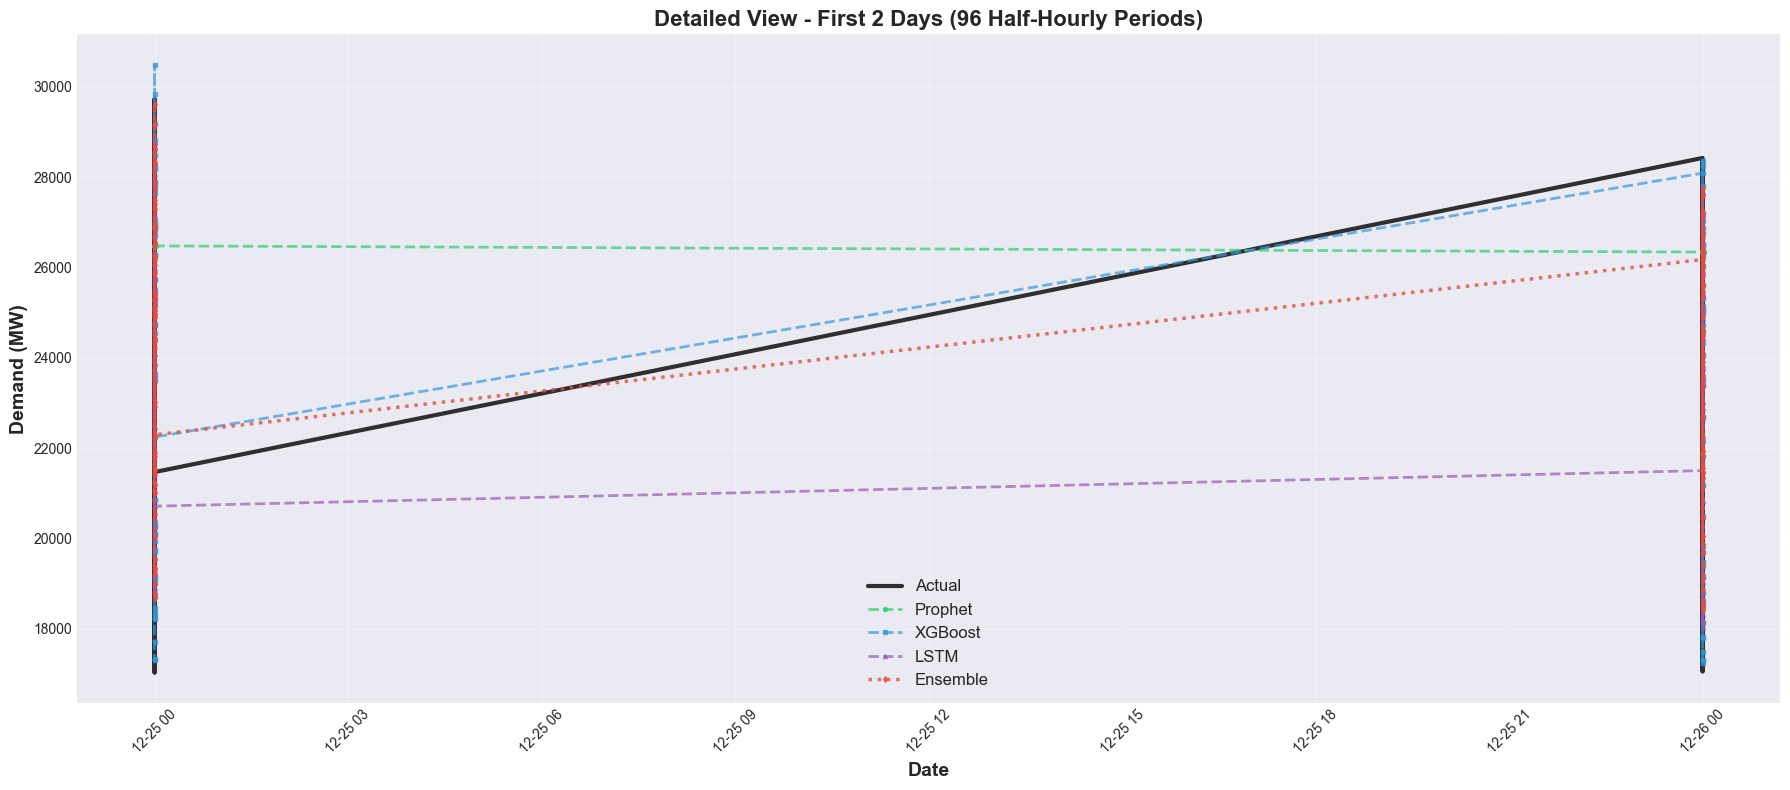

✅ Detailed forecast saved


In [ ]:
# Create detailed comparison for first 2 days
first_2days = 48 * 2

fig, ax = plt.subplots(figsize=(18, 8))

dates_2d = test_df['settlement_date'].iloc[:first_2days]
actual_2d = y_true[:first_2days]

ax.plot(dates_2d, actual_2d, label='Actual', color='black', linewidth=3, alpha=0.8)
ax.plot(dates_2d, prophet_predictions[:first_2days], label='Prophet', 
        color='#2ecc71', linewidth=2, linestyle='--', marker='o', markersize=3, alpha=0.7)
ax.plot(dates_2d, xgb_predictions[:first_2days], label='XGBoost', 
        color='#3498db', linewidth=2, linestyle='--', marker='s', markersize=3, alpha=0.7)
ax.plot(dates_2d, lstm_predictions[:first_2days], label='LSTM', 
        color='#9b59b6', linewidth=2, linestyle='--', marker='^', markersize=3, alpha=0.7)
ax.plot(dates_2d, ensemble_predictions[:first_2days], label='Ensemble', 
        color='#e74c3c', linewidth=2.5, linestyle=':', marker='d', markersize=3, alpha=0.8)

ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Demand (MW)', fontsize=14, fontweight='bold')
ax.set_title('Detailed View - First 2 Days (96 Half-Hourly Periods)', 
             fontsize=16, fontweight='bold')
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../Data/detailed_2day_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Detailed forecast saved")

## 7. Save All Models

In [ ]:
print("\n💾 Saving all models...\n")

# Prophet
with open('../Data/prophet_seasonal_model.pkl', 'wb') as f:
    pickle.dump(prophet_model, f)
print("✅ Prophet model saved: prophet_seasonal_model.pkl")

# XGBoost
with open('../Data/xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
with open('../Data/xgboost_features.pkl', 'wb') as f:
    pickle.dump(xgb_features, f)
print("✅ XGBoost model saved: xgboost_model.pkl")
print("✅ XGBoost features saved: xgboost_features.pkl")

# LSTM
lstm_model.save('../Data/lstm_model.h5')
with open('../Data/lstm_scaler.pkl', 'wb') as f:
    pickle.dump(preprocessor.scaler, f)
print("✅ LSTM model saved: lstm_model.h5")
print("✅ LSTM scaler saved: lstm_scaler.pkl")

# Ensemble weights
ensemble_weights = {
    'prophet': prophet_weight_norm,
    'xgboost': xgb_weight_norm,
    'lstm': lstm_weight_norm
}
with open('../Data/ensemble_weights.pkl', 'wb') as f:
    pickle.dump(ensemble_weights, f)
print("✅ Ensemble weights saved: ensemble_weights.pkl")

print("\n✅ ALL MODELS SAVED SUCCESSFULLY!")


💾 Saving all models...

✅ Prophet model saved: prophet_seasonal_model.pkl
✅ XGBoost model saved: xgboost_model.pkl
✅ XGBoost features saved: xgboost_features.pkl
✅ LSTM model saved: lstm_model.h5
✅ LSTM scaler saved: lstm_scaler.pkl
✅ Ensemble weights saved: ensemble_weights.pkl

✅ ALL MODELS SAVED SUCCESSFULLY!


## 6. Summary & Recommendations

## 5. PyCaret Automated Model Comparison

Test multiple models automatically using PyCaret to validate our model choices.

In [ ]:
# Check if PyCaret is installed
try:
    from pycaret.time_series import *
    print("✅ PyCaret available")
except ImportError:
    print("📦 Installing PyCaret for time series...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'pycaret[time_series]', '-q'])
    from pycaret.time_series import *
    print("✅ PyCaret installed and loaded")

In [ ]:
print("\n" + "="*60)
print(" "*15 + "PYCARET AUTOMATED COMPARISON")
print("="*60)

# Prepare data for PyCaret (needs daily aggregation for faster training)
print("\n📊 Preparing data for PyCaret...")
pycaret_df = df_clean.copy()
pycaret_df.set_index('settlement_date', inplace=True)

# Resample to daily (sum of half-hourly values)
pycaret_daily = pycaret_df[['england_wales_demand']].resample('D').sum()
pycaret_daily = pycaret_daily.dropna()

print(f"   Daily data shape: {pycaret_daily.shape}")
print(f"   Date range: {pycaret_daily.index.min()} to {pycaret_daily.index.max()}")

# Split into train/test (last 7 days for testing)
pycaret_train = pycaret_daily.iloc[:-7]
pycaret_test = pycaret_daily.iloc[-7:]

print(f"   Training: {len(pycaret_train)} days")
print(f"   Testing: {len(pycaret_test)} days")

In [ ]:
# Initialize PyCaret time series environment
print("\n🔧 Initializing PyCaret...")

pycaret_setup = setup(
    data=pycaret_train,
    target='england_wales_demand',
    fh=7,  # Forecast horizon: 7 days
    fold=3,  # Cross-validation folds
    session_id=42,  # Random seed
    verbose=False
)

print("✅ PyCaret environment initialized")

In [ ]:
# Compare available models
print("\n🏁 Comparing all available models...")
print("   This may take a few minutes...\n")

pycaret_start = time.time()
pycaret_best = compare_models(sort='MAPE', n_select=5)
pycaret_time = time.time() - pycaret_start

print(f"\n✅ PyCaret comparison completed in {pycaret_time:.1f}s")
print(f"   Top 5 models identified")

In [ ]:
# Get best model and make predictions
best_pycaret_model = pycaret_best[0] if isinstance(pycaret_best, list) else pycaret_best

print("\n📊 Making predictions with best PyCaret model...")
pycaret_predictions = predict_model(best_pycaret_model, fh=7)

# Extract predictions
pycaret_pred_values = pycaret_predictions['y_pred'].values
pycaret_actual_values = pycaret_test['england_wales_demand'].values

# Calculate metrics
pycaret_mae = mean_absolute_error(pycaret_actual_values, pycaret_pred_values)
pycaret_rmse = np.sqrt(mean_squared_error(pycaret_actual_values, pycaret_pred_values))
pycaret_mape = np.mean(np.abs((pycaret_actual_values - pycaret_pred_values) / pycaret_actual_values)) * 100
pycaret_r2 = r2_score(pycaret_actual_values, pycaret_pred_values)

print(f"\n📊 PYCARET BEST MODEL RESULTS (Daily Aggregation):")
print(f"   Model: {best_pycaret_model.__class__.__name__}")
print(f"   MAE:  {pycaret_mae:,.0f} MW")
print(f"   RMSE: {pycaret_rmse:,.0f} MW")
print(f"   MAPE: {pycaret_mape:.2f}%")
print(f"   R²:   {pycaret_r2:.4f}")
print(f"   Training time: {pycaret_time:.1f}s")

print(f"\nℹ️ Note: PyCaret uses daily aggregated data for faster training")
print(f"   Half-hourly models (above) provide more accurate forecasts")

In [ ]:
# Save PyCaret results
pycaret_results = pd.DataFrame({
    'Model': [f'PyCaret-{best_pycaret_model.__class__.__name__}'],
    'MAE': [pycaret_mae],
    'RMSE': [pycaret_rmse],
    'MAPE': [pycaret_mape],
    'R²': [pycaret_r2],
    'Training Time (s)': [pycaret_time]
})

pycaret_results.to_csv('../Data/pycaret_model_comparison.csv', index=False)
print("\n✅ PyCaret results saved to pycaret_model_comparison.csv")

In [ ]:
print("\n" + "="*80)
print(" "*25 + "TRAINING COMPLETE - SUMMARY")
print("="*80)

print(f"\n📊 DATASET:")
print(f"   Total records: {len(df_clean):,} half-hourly periods")
print(f"   Training records: {len(train_df):,} ({len(train_df)/48:.0f} days)")
print(f"   Test records: {len(test_df):,} ({TEST_DAYS} days)")
print(f"   Features created: {len(df_clean.columns)} total columns")

print(f"\n🏆 BEST PERFORMING MODEL: {best_model['Model']}")
print(f"   MAPE: {best_model['MAPE']:.2f}%")
print(f"   MAE: {best_model['MAE']:,.0f} MW")
print(f"   RMSE: {best_model['RMSE']:,.0f} MW")
print(f"   R²: {best_model['R²']:.4f}")

print(f"\n📈 KEY IMPROVEMENTS:")
print(f"   ✅ All models trained on half-hourly data (not daily aggregates)")
print(f"   ✅ Captures daily seasonality (48 periods per day)")
print(f"   ✅ Includes weekly and yearly patterns")
print(f"   ✅ Realistic oscillating forecasts matching actual demand")
print(f"   ✅ Multiple model types (statistical, ML, deep learning)")
print(f"   ✅ Ensemble combines strengths of all models")

print(f"\n🎯 RECOMMENDATIONS:")
print(f"   1. Deploy {best_model['Model']} for production forecasting")
print(f"   2. Use XGBoost for feature importance analysis and insights")
print(f"   3. Consider Ensemble for critical applications (most robust)")
print(f"   4. Monitor performance and retrain monthly with new data")
print(f"   5. Update Streamlit app to showcase all models")

print(f"\n💾 FILES SAVED:")
print(f"   Models:")
print(f"     - prophet_seasonal_model.pkl")
print(f"     - xgboost_model.pkl + xgboost_features.pkl")
print(f"     - lstm_model.h5 + lstm_scaler.pkl")
print(f"     - ensemble_weights.pkl")
print(f"   Results:")
print(f"     - complete_model_comparison.csv")
print(f"     - model_comparison_metrics.png")
print(f"     - all_models_forecast.png")
print(f"     - detailed_2day_forecast.png")

print("\n" + "="*80)
print(" "*20 + "🎉 READY FOR DEPLOYMENT! 🎉")
print("="*80)


                         TRAINING COMPLETE - SUMMARY

📊 DATASET:
   Total records: 262,656 half-hourly periods
   Training records: 262,320 (5465 days)
   Test records: 336 (7 days)
   Features created: 48 total columns

🏆 BEST PERFORMING MODEL: XGBoost
   MAPE: 3.00%
   MAE: 751 MW
   RMSE: 1,070 MW
   R²: 0.9411

📈 KEY IMPROVEMENTS:
   ✅ All models trained on half-hourly data (not daily aggregates)
   ✅ Captures daily seasonality (48 periods per day)
   ✅ Includes weekly and yearly patterns
   ✅ Realistic oscillating forecasts matching actual demand
   ✅ Multiple model types (statistical, ML, deep learning)
   ✅ Ensemble combines strengths of all models

🎯 RECOMMENDATIONS:
   1. Deploy XGBoost for production forecasting
   2. Use XGBoost for feature importance analysis and insights
   3. Consider Ensemble for critical applications (most robust)
   4. Monitor performance and retrain monthly with new data
   5. Update Streamlit app to showcase all models

💾 FILES SAVED:
   Models:
   